<a href="https://colab.research.google.com/github/mahoangnhatphi/prj/blob/main/app.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Step 0: Import Datasets

In [67]:
# Install kaggle
!pip install kaggle

In [68]:
!rm -rf kaggle

In [69]:
from google.colab import drive
drive.mount('/content/drive')
!unzip /content/drive/MyDrive/dog-breeds.zip -d ./kaggle

Streaming output truncated to the last 5000 lines.
  inflating: ./kaggle/data/test/Gordon Setter/n02101006_591.jpg  
  inflating: ./kaggle/data/test/Gordon Setter/n02101006_709.jpg  
  inflating: ./kaggle/data/test/Gordon Setter/n02101006_8067.jpg  
   creating: ./kaggle/data/test/Great Dane/
  inflating: ./kaggle/data/test/Great Dane/dane-2.jpg  
  inflating: ./kaggle/data/test/Great Dane/n02109047_10112.jpg  
  inflating: ./kaggle/data/test/Great Dane/n02109047_11178.jpg  
  inflating: ./kaggle/data/test/Great Dane/n02109047_2248.jpg  
  inflating: ./kaggle/data/test/Great Dane/n02109047_2527.jpg  
  inflating: ./kaggle/data/test/Great Dane/n02109047_25291.jpg  
  inflating: ./kaggle/data/test/Great Dane/n02109047_25603.jpg  
  inflating: ./kaggle/data/test/Great Dane/n02109047_26134.jpg  
  inflating: ./kaggle/data/test/Great Dane/n02109047_2810.jpg  
  inflating: ./kaggle/data/test/Great Dane/n02109047_282.jpg  
  inflating: ./kaggle/data/test/Great Dane/n02109047_32635.jpg  
  inf

In [70]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

import os
# Cấu hình secret key để xác thực truy cập đến Kaggle trên môi trường
os.environ['KAGGLE_USERNAME'] = 'phimhongnht'
os.environ['KAGGLE_KEY'] = '9a66e2c809122b723bbd83a30e78c0ca'

if not os.path.exists('./kaggle/data'):
  !kaggle datasets download -d phimhongnht/dog-breeds -p ./
  !unzip  ./*.zip -d ./kaggle
else:
    print('File already exists, no need to download or unzip.')

print(os.listdir('./kaggle'))

File already exists, no need to download or unzip.
['data']


In [71]:
import numpy as np
from glob import glob

# load filenames for dog images
dog_files = np.array(glob("/content/kaggle/data/*/*/*"))

# print number of images in each dataset
print('There are %d total dog images.' % len(dog_files))

There are 5724 total dog images.


In [72]:
# %%time
# # https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip
# # https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/lfw.zip

# import requests, zipfile, io, os, shutil

# root = '/content'
# dogimages_url = "https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip"
# humanimages_url = "https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/lfw.zip"

# data_path = os.path.join(root,'data')
# dogimages_path = os.path.join(data_path,'dogImages')
# humanimages_path = os.path.join(data_path,'lfw')
# data_path = os.path.join(root,'data')
# if not os.path.exists(data_path): os.mkdir(data_path)

# # if os.path.exists(dogimages_path):shutil.rmtree(dogimages_path)
# # if os.path.exists(humanimages_path):shutil.rmtree(humanimages_path)

# if not os.path.exists(dogimages_path):
#   print("downloading dog images")
#   r = requests.get(dogimages_url)
#   z = zipfile.ZipFile(io.BytesIO(r.content))
#   z.extractall(data_path)

# if not os.path.exists(humanimages_path):
#   print("downloading human images")
#   r = requests.get(humanimages_url)
#   z = zipfile.ZipFile(io.BytesIO(r.content))
#   z.extractall(data_path)

# import numpy as np
# from glob import glob

# # load filenames for human and dog images
# human_files = np.array(glob("/content/data/lfw/*/*"))
# dog_files = np.array(glob("/content/data/dogImages/*/*/*"))

# # print number of images in each dataset
# print('There are %d total human images.' % len(human_files))
# print('There are %d total dog images.' % len(dog_files))

In [ ]:
if not os.path.exists('/content/haarcascades'): os.mkdir('/content/haarcascades')
haarcascades_url = 'https://raw.githubusercontent.com/opencv/opencv/master/data/haarcascades/haarcascade_frontalface_alt.xml'
!wget -O /content/haarcascades/haarcascade_frontalface_alt.xml {haarcascades_url}

--2023-09-02 11:28:42--  https://raw.githubusercontent.com/opencv/opencv/master/data/haarcascades/haarcascade_frontalface_alt.xml
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 676709 (661K) [text/plain]
Saving to: ‘/content/haarcascades/haarcascade_frontalface_alt.xml’

/content/haarcascad 100%[===================>] 660.85K  --.-KB/s    in 0.05s   

2023-09-02 11:28:43 (12.7 MB/s) - ‘/content/haarcascades/haarcascade_frontalface_alt.xml’ saved [676709/676709]



In [75]:
from sklearn.datasets import load_files
from keras.utils import np_utils
import numpy as np
from glob import glob
# define function to load train, test, and validation datasets
def load_dataset(path):
    data = load_files(path)
    dog_files = np.array(data['filenames'])
    dog_targets = np_utils.to_categorical(np.array(data['target']), 149)
    return dog_files, dog_targets

# load train, test, and validation datasets
train_files, train_targets = load_dataset('/content/kaggle/data/train')
valid_files, valid_targets = load_dataset('/content/kaggle/data/valid')
test_files, test_targets = load_dataset('/content/kaggle/data/test')

# load list of dog names
dog_names = [item[20:-1] for item in sorted(glob("/content/kaggle/data/train/*/"))]

# print statistics about the dataset
print('There are %d total dog categories.' % len(dog_names))
print('There are %s total dog images.\n' % len(np.hstack([train_files, valid_files, test_files])))
print('There are %d training dog images.' % len(train_files))
print('There are %d validation dog images.' % len(valid_files))
print('There are %d test dog images.'% len(test_files))

There are 149 total dog categories.
There are 5724 total dog images.

There are 1907 training dog images.
There are 1335 validation dog images.
There are 2482 test dog images.


Step 1: Detect Dogs

In [ ]:
# Write a Dog Detector

In [76]:
# #Obtain Pre-trained VGG-16 Model
# import torch
# import torchvision.models as models

# # define VGG16 model
# VGG16 = models.vgg16(pretrained=True)

# # check if CUDA is available
# use_cuda = torch.cuda.is_available()

# # move model to GPU if CUDA is available
# if use_cuda:
#     VGG16 = VGG16.cuda()

In [77]:
# from PIL import Image
# import torchvision.transforms as transforms
# from torch.utils.data import DataLoader
# from torchvision import datasets
# import os

# def VGG16_predict(img_path):
#     '''
#     Use pre-trained VGG-16 model to obtain index corresponding to
#     predicted ImageNet class for image at specified path

#     Args:
#         img_path: path to an image

#     Returns:
#         Index corresponding to VGG-16 model's prediction
#     '''

#     ## TODO: Complete the function.
#     ## Load and pre-process an image from the given img_path
#     ## Return the *index* of the predicted class for that image

#     # data transformation
#     batch_size = 64
#     img = Image.open(img_path).convert('RGB')
#     image_transforms = transforms.Compose([
#                             transforms.RandomResizedCrop(size=256, scale=(0.8, 1.0)),
#                             transforms.RandomRotation(degrees=15),
#                             transforms.ColorJitter(),
#                             transforms.RandomHorizontalFlip(),
#                             transforms.CenterCrop(size=224),  # Image net standards
#                             transforms.ToTensor(),
#                             transforms.Normalize([0.485, 0.456, 0.406],
#                                                  [0.229, 0.224, 0.225])  # Imagenet standards
#                         ])

#     image = image_transforms(img)[:3,:,:].unsqueeze(0)
# #     image = image_transforms(img)
# #     print(image_transformation)

#     if use_cuda:
#         image = image.cuda()
#     output = VGG16(image)

#     _,pred = torch.max(output, dim=1)
#     pred=pred.cpu()
#     pred = pred.data.numpy()[0]

#     return pred # predicted class index

# VGG16_predict(dog_files[0])

181

In [102]:
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing.image import load_img
from keras.applications import imagenet_utils

# define ResNet50 model
ResNet50_model = ResNet50(weights='imagenet')

def ResNet50_predict_labels(img_path):
    # returns prediction vector for image located at img_path
    img = preprocess_input(path_to_tensor(img_path))
    return np.argmax(ResNet50_model.predict(img))

In [104]:
### returns "True" if a dog is detected in the image stored at img_path
def dog_detector(img_path):
    ## TODO: Complete the function.
#     in VGG16 index 151 to 268 are dog classifications

    return VGG16_predict(img_path)>= 151 and VGG16_predict(img_path)<=268 # true/false

print(dog_detector(dog_files[4]))

True


In [105]:
### returns "True" if a dog is detected in the image stored at img_path
def dog_detector(img_path):
    prediction = ResNet50_predict_labels(img_path)
    return ((prediction <= 268) & (prediction >= 151))

In [106]:
import keras.utils as image
from tqdm import tqdm

def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(224, 224))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

In [ ]:
### TODO: Test the performance of the dog_detector function
### on the images in human_files_short and dog_files_short.

v_dog_detector = np.vectorize(dog_detector)

dog_result = v_dog_detector(dog_files)
print("Percent of dog dog files:", (sum(dog_result)/100)*100)

1/1 [==============================] - 0s 225ms/step


Pre-process the Data

In [83]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

# pre-process the data for Keras
train_tensors = paths_to_tensor(train_files).astype('float32')/255
valid_tensors = paths_to_tensor(valid_files).astype('float32')/255
test_tensors = paths_to_tensor(test_files).astype('float32')/255

100%|██████████| 2482/2482 [00:16<00:00, 151.47it/s]


In [47]:
# CNN
from keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_path = '/content/kaggle/data/train/'
val_path = '/content/kaggle/data/valid'
test_path = '/content/kaggle/data/test'

batch_size=64
train_generator = train_datagen.flow_from_directory(
        train_path,
        # '/content/cats_dogs/data/train',  # this is the target directory
        target_size=(150, 150),  # all images will be resized to 150x150
        batch_size=batch_size,
        class_mode='categorical')

validation_generator = val_datagen.flow_from_directory(
        val_path,
        # '/content/cats_dogs/data/val',
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='categorical')

test_generator = val_datagen.flow_from_directory(
        test_path,
        # '/content/cats_dogs/data/val',
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='categorical')

Found 426 images belonging to 147 classes.
Found 426 images belonging to 147 classes.
Found 426 images belonging to 147 classes.


 Model Architecture
Create a CNN to classify dog breed. At the end of your code cell block, summarize the layers of your model by executing the line:

    model.summary()

Steps I took to get the final CNN architecture. I've used the hinted architecture above. The steps are

1. Declared a model with Keras Sequential API.
2. Then added a Convolution layer with input shape (224,224,3)
3. Added a Maxpooling layer with pool_size 2 and activation function relu.
4. Added Convolution layer with 32 filters, kernel size 2, and activation function relu.
5. Added another Maxpooling layer with pool_size 2.
6. Added Convolution layer with 64 filters, kernel size 2, and activation function relu.
7. Added another Maxpooling layer with pool_size 2.
8. Added global average pooling layer.
9. Added final output dense layer with 133 output category and softmax activation function.


In [87]:
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential

model = Sequential()

### TODO: Define your architecture.
model = Sequential()
model.add(Conv2D(filters=16, kernel_size=2, padding='same', activation='relu', input_shape=(224, 224, 3)))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=32, kernel_size=2, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=64, kernel_size=2, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(GlobalAveragePooling2D())
model.add(Dense(149, activation='softmax'))
model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 224, 224, 16)      208       
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 112, 112, 16)     0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 112, 112, 32)      2080      
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 56, 56, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 56, 56, 64)        8256      
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 28, 28, 64)      

Compile the Model

In [97]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

Train and Validate the model

In [98]:
from keras.callbacks import ModelCheckpoint

### TODO: specify the number of epochs that you would like to use to train the model.

epochs = 10

### Do NOT modify the code below this line.

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.from_scratch.hdf5',
                               verbose=1, save_best_only=True)

model.fit(train_tensors, train_targets,
          validation_data=(valid_tensors, valid_targets),
          epochs=epochs, batch_size=20, callbacks=[checkpointer], verbose=1)

Epoch 1/10


ValueError: ignored

Load the Model with the Best Validation Loss

In [ ]:
# get index of predicted dog breed for each image in test set
dog_breed_predictions = [np.argmax(model.predict(np.expand_dims(tensor, axis=0))) for tensor in test_tensors]

# report test accuracy
test_accuracy = 100*np.sum(np.array(dog_breed_predictions)==np.argmax(test_targets, axis=1))/len(dog_breed_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

# Use a CNN to Classify Dog Breeds

## Obtain Bottleneck Features

In [ ]:
bottleneck_features = np.load('bottleneck_features/DogVGG16Data.npz')
train_VGG16 = bottleneck_features['train']
valid_VGG16 = bottleneck_features['valid']
test_VGG16 = bottleneck_features['test']

Model Architecture

In [ ]:
VGG16_model = Sequential()
VGG16_model.add(GlobalAveragePooling2D(input_shape=train_VGG16.shape[1:]))
VGG16_model.add(Dense(133, activation='softmax'))

VGG16_model.summary()

Compile the Model

In [ ]:
VGG16_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

### Train the Model

In [ ]:
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.VGG16.hdf5',
                               verbose=1, save_best_only=True)

VGG16_model.fit(train_VGG16, train_targets,
          validation_data=(valid_VGG16, valid_targets),
          epochs=20, batch_size=20, callbacks=[checkpointer], verbose=1)

### Load the Model with the Best Validation Loss

In [ ]:
VGG16_model.load_weights('saved_models/weights.best.VGG16.hdf5')

### Test the Model

In [96]:
# get index of predicted dog breed for each image in test set
VGG16_predictions = [np.argmax(VGG16_model.predict(np.expand_dims(feature, axis=0))) for feature in test_VGG16]

# report test accuracy
test_accuracy = 100*np.sum(np.array(VGG16_predictions)==np.argmax(test_targets, axis=1))/len(VGG16_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

[]

## Predict Dog Breed with the Model

In [ ]:
from extract_bottleneck_features import *

def VGG16_predict_breed(img_path):
    # extract bottleneck features
    bottleneck_feature = extract_VGG16(path_to_tensor(img_path))
    # obtain predicted vector
    predicted_vector = VGG16_model.predict(bottleneck_feature)
    # return dog breed that is predicted by the model
    return dog_names[np.argmax(predicted_vector)]

# Create a CNN to Classify Dog Breeds (using Transfer Learning)

## Obtain Bottleneck Features
In the code block below, extract the bottleneck features corresponding to the train, test, and validation sets by running the following:

bottleneck_features = np.load('bottleneck_features/Dog{network}Data.npz')
train_{network} = bottleneck_features['train']
valid_{network} = bottleneck_features['valid']
test_{network} = bottleneck_features['test']

In [ ]:
# ResNet-50 bottleneck features
### TODO: Obtain bottleneck features from another pre-trained CNN.
bottleneck_features = np.load('bottleneck_features/DogResnet50Data.npz')
train_Resnet50 = bottleneck_features['train']
valid_Resnet50 = bottleneck_features['valid']
test_Resnet50 = bottleneck_features['test']

## Model architecture

In [ ]:
### TODO: Define your architecture.
Resnet50_model = Sequential()
Resnet50_model.add(GlobalAveragePooling2D(input_shape = train_Resnet50.shape[1:]))
Resnet50_model.add(Dense(133, activation='softmax'))
Resnet50_model.summary()

In [ ]:
### Compile the Model
### TODO: Compile the model.
Resnet50_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

## Train the Model

In [ ]:
### TODO: Train the model.
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.Resnet50.hdf5',
                               verbose=1, save_best_only=True)

Resnet50_model.fit(train_Resnet50, train_targets,
          validation_data=(valid_Resnet50, valid_targets),
          epochs=20, batch_size=20, callbacks=[checkpointer], verbose=1)

## Load the Model with the Best Validation Loss

In [ ]:
### TODO: Load the model weights with the best validation loss.
Resnet50_model.load_weights('saved_models/weights.best.Resnet50.hdf5')

## Test the Model

In [ ]:
# save the model to file
Resnet50_model.save('saved_models/Resnet50.h5')

In [ ]:
### TODO: Calculate classification accuracy on the test dataset.
# get index of predicted dog breed for each image in test set
Resnet50_predictions = [np.argmax(Resnet50_model.predict(np.expand_dims(feature, axis=0))) for feature in test_Resnet50]

# report test accuracy
test_accuracy = 100*np.sum(np.array(Resnet50_predictions)==np.argmax(test_targets, axis=1))/len(Resnet50_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

## Predict Dog Breed with the Model

In [ ]:
### TODO: Write a function that takes a path to an image as input
### and returns the dog breed that is predicted by the model.
from extract_bottleneck_features import *

def Resnet50_predict_breed(img_path):
    # extract bottleneck features
    bottleneck_feature = extract_Resnet50(path_to_tensor(img_path))
    # obtain predicted vector
    predicted_vector = Resnet50_model.predict(bottleneck_feature)
    # return dog breed that is predicted by the model
    return dog_names[np.argmax(predicted_vector)].split(".")[1]

In [ ]:
# test Dog Breed with the Model
dog_img = dog_files_short[0]
print(Resnet50_predict_breed(dog_img))
plt.imshow(cv2.imread(dog_files_short[0]))

In [ ]:
# test Dog Breed with the Model
dog_img = dog_files_short[50]
print(Resnet50_predict_breed(dog_img))
plt.imshow(cv2.imread(dog_files_short[50]))

CNN to classfiy dog breeds

In [53]:
## TODO: Specify data loaders
from keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_path = '/content/kaggle/data/train/'
val_path = '/content/kaggle/data/valid'
test_path = '/content/kaggle/data/test'

batch_size=64
train_generator = train_datagen.flow_from_directory(
        train_path,
        # '/content/cats_dogs/data/train',  # this is the target directory
        target_size=(150, 150),  # all images will be resized to 150x150
        batch_size=batch_size,
        class_mode='categorical')

validation_generator = val_datagen.flow_from_directory(
        val_path,
        # '/content/cats_dogs/data/val',
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='categorical')

test_generator = val_datagen.flow_from_directory(
        test_path,
        # '/content/cats_dogs/data/val',
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='categorical')

Found 426 images belonging to 147 classes.
Found 426 images belonging to 147 classes.
Found 426 images belonging to 147 classes.


In [90]:
from time import time
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D, Activation, Dropout, Flatten, Dense
from keras.optimizers import SGD
from keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
from keras.applications.vgg16 import VGG16 as PTModel, preprocess_input
import keras
keras.backend.set_learning_phase(1)

img_rows, img_cols, img_channel = 150, 150, 3
base_model = PTModel(weights='imagenet'
                     ,include_top=False, input_shape=(img_rows, img_cols, img_channel), classes = 2)
add_model = Sequential()
add_model.add(Flatten(input_shape=base_model.output_shape[1:]))
add_model.add(Dense(64, activation='relu'))
add_model.add(Dense(147, activation='sigmoid'))

model = Model(inputs=base_model.input, outputs=add_model(base_model.output))

for layer in base_model.layers:
    layer.trainable = False

    if layer.name.startswith('bn'):
        layer.call(layer.input, training=False)

In [60]:
model.compile(loss='binary_crossentropy',
              optimizer=SGD(lr=1e-4, momentum=0.9),
              metrics=['accuracy'])

In [61]:
check_point_name = 'vgg16.model'
model_weights = 'vgg16.h5'

start_time = time()
model.fit_generator(
        train_generator,
        epochs=2,
        validation_data=validation_generator,
        #class_weight = class_weights,
        callbacks=[ModelCheckpoint(check_point_name, monitor='val_acc', save_best_only=True)])
model.save_weights(model_weights)

print('time taken ',time()-start_time)

<ipython-input-61-89b5a1d2250c>:5: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(


Epoch 1/2
7/7 [==============================] - ETA: 0s - loss: 0.7262 - accuracy: 0.0094 

7/7 [==============================] - 244s 37s/step - loss: 0.7262 - accuracy: 0.0094 - val_loss: 0.7248 - val_accuracy: 0.0070
Epoch 2/2
7/7 [==============================] - ETA: 0s - loss: 0.7205 - accuracy: 0.0117 

7/7 [==============================] - 259s 40s/step - loss: 0.7205 - accuracy: 0.0117 - val_loss: 0.7183 - val_accuracy: 0.0070
time taken  523.365006685257


In [62]:
# test(loaders_transfer, model_transfer, criterion_transfer, use_cuda)
test_generator.reset()
STEP_SIZE_TEST=test_generator.n//test_generator.batch_size
test_eval = model.evaluate_generator(test_generator,STEP_SIZE_TEST)
print('test loss ',test_eval[0])
print('test accuracy ',test_eval[1])

<ipython-input-62-58b79be3ab5f>:4: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  test_eval = model.evaluate_generator(test_generator,STEP_SIZE_TEST)


test loss  0.7181933522224426
test accuracy  0.010416666977107525


In [63]:
### TODO: Write a function that takes a path to an image as input
### and returns the dog breed that is predicted by the model.

# list of class names by index, i.e. a name can be accessed like class_names[0]
# class_names = [item[4:].replace("_", " ") for item in data_transfer['train'].classes]
from PIL import Image
import numpy as np
from skimage import transform

def load(filename):
   np_image = Image.open(filename)
   np_image = np.array(np_image).astype('float32')/255
   np_image = transform.resize(np_image, (150, 150, 3))
   np_image = np.expand_dims(np_image, axis=0)
   return np_image

def predict_breed_transfer(img_path):
    # load the image and return the predicted breed
  image = load(img_path)
  y_prob = model.predict(image)
  y_class = y_prob.argmax(axis=-1)
  # print(y_classes)
  labels = (train_generator.class_indices)
  labels = dict((v,k) for k,v in labels.items())
  prediction = [labels[k] for k in y_class]
  return prediction

Write your Algorithm

In [64]:
### TODO: Write your algorithm.
### Feel free to use as many code cells as needed.
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
def run_app(img_path):
    img = mpimg.imread(img_path)

    # Display the image
    plt.imshow(img)
    plt.axis('off')  # This removes axis labels and ticks
    plt.show()
    ## handle cases for a human face, dog, and neither
    if dog_detector(img_path):
      print('This is image of dog')

      prediction = predict_breed_transfer(img_path)
      print(prediction)
    else:
      print("couldn't detect dog or human image")



In [99]:
dog_files[4:6]

array(['/content/kaggle/data/test/Bedlington Terrier/n02093647_2743.jpg',
       '/content/kaggle/data/test/Bedlington Terrier/n02093647_2427.jpg'],
      dtype='<U90')

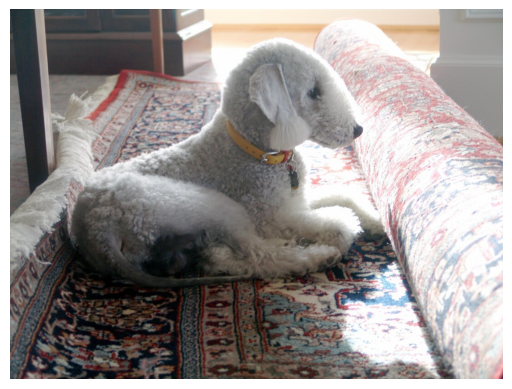

1/1 [==============================] - 0s 245ms/step
This is image of dog
1/1 [==============================] - 0s 268ms/step
['Samoyed']


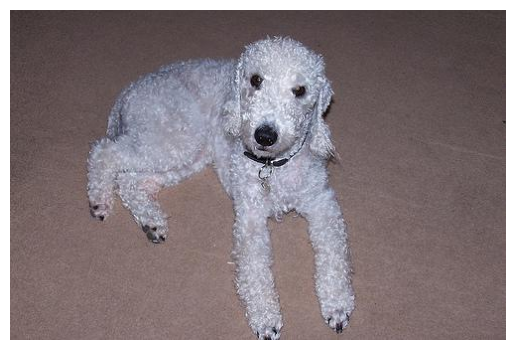

1/1 [==============================] - 0s 263ms/step
This is image of dog
1/1 [==============================] - 0s 327ms/step
['Samoyed']


In [101]:
## TODO: Execute your algorithm from Step 6 on
## at least 6 images on your computer.
## Feel free to use as many code cells as needed.

## suggested code, below
for file in np.hstack(dog_files[4:6]):
    run_app(file)